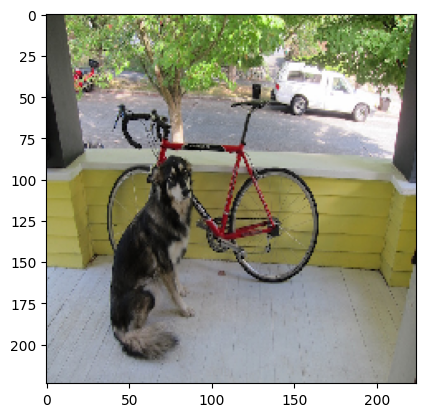

In [9]:
from tensorflow import keras
import matplotlib.pyplot as plt
# from google.colab import drive
# drive.mount('/content/drive')

# image_path = '/content/drive/MyDrive/ColabNotebooks/02_TestData/01_VGG16/dog.jpg'
image_path = './dog.jpg'
# image_path = './cup.jpg'
img = keras.utils.load_img(image_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

In [ ]:
!ls drive/

In [10]:
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

model = VGG16(weights='imagenet', include_top=True)

x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=5)[0])

1/1 [==============================] - 0s 73ms/step
Predicted: [('n02110063', 'malamute', 0.31755283), ('n02110185', 'Siberian_husky', 0.21920896), ('n02109961', 'Eskimo_dog', 0.15373069), ('n03218198', 'dogsled', 0.054454904), ('n02106166', 'Border_collie', 0.043012597)]


In [11]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=5)[0])

1/1 [==============================] - 0s 12ms/step
Predicted: [('n02110063', 'malamute', 0.31755283), ('n02110185', 'Siberian_husky', 0.21920896), ('n02109961', 'Eskimo_dog', 0.15373069), ('n03218198', 'dogsled', 0.054454904), ('n02106166', 'Border_collie', 0.043012597)]


In [12]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz

In [ ]:
!ls

In [ ]:
!tar xvzf imagenette2-320.tgz

In [ ]:
!ls ./imagenette2-320/train

In [ ]:
json_path = keras.utils.get_file("imagenet_class_index.json", "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json")

import json
with open(json_path) as json_file:
  imagenet_class_index = json.load(json_file)

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow import keras
import numpy as np

SAVE_DIR = '.'
model = VGG16(weights=None, classes=10)
try:
  model.load_weights(SAVE_DIR+'best_model.h5')
  print('load done')
except:
  pass

from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

DATA_DIR = 'imagenette2-320'

train_it = datagen.flow_from_directory(DATA_DIR+'/train/', target_size=(224, 224), class_mode='categorical', batch_size=64)
val_it = datagen.flow_from_directory(DATA_DIR+'/val/', target_size=(224, 224), class_mode='categorical', batch_size=64)

checkpoint = ModelCheckpoint(SAVE_DIR+"/best_model.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

from tensorflow.keras.callbacks import Callback

class LrReducer(Callback):
    def __init__(self, patience=0, reduce_rate=0.5, reduce_nb=10, verbose=1):
        super(Callback, self).__init__()
        self.patience = patience
        self.wait = 0
        self.best_score = -1.
        self.reduce_rate = reduce_rate
        self.current_reduce_nb = 0
        self.reduce_nb = reduce_nb
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        #current_score = logs.get('val_accuracy')
        current_score = logs.get('accuracy')
        if current_score > self.best_score:
            self.best_score = current_score
            self.wait = 0
            if self.verbose > 0:
                print('---current best score: %.3f' % current_score)
        else:
            if self.wait >= self.patience:
                self.current_reduce_nb += 1
                if self.current_reduce_nb <= 10:
                    lr = keras.backend.get_value(self.model.optimizer.lr)
                    keras.backend.set_value(self.model.optimizer.lr, lr*self.reduce_rate)
                    if self.verbose > 0:
                        print('---lr decreasing: %e' % (lr*self.reduce_rate))
                else:
                    if self.verbose > 0:
                        print("Epoch %d: early stopping" % (epoch))
                    self.model.stop_training = True
            self.wait += 1
lrreducer = LrReducer(patience=5)
# fit model
history = model.fit(train_it, steps_per_epoch=16, validation_data=val_it,
          validation_steps=8,
          epochs=10, callbacks=[checkpoint,lrreducer])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:

class_indices = list(train_it.class_indices.keys())
class_values = list(val_it.class_indices.values())
class_names=[]
for i in range(1000):
  if imagenet_class_index['{}'.format(i)][0] in class_indices:
    class_names.append(imagenet_class_index['{}'.format(i)][1])

In [ ]:

train_it.class_indices

In [ ]:

model2 = keras.models.load_model(SAVE_DIR+"/best_model.h5")
model2.summary()

In [ ]:

#image_path2 = 'imagenette2-320/val/n02102040/n02102040_7501.JPEG'
#image_path2 = 'imagenette2-320/val/n03028079/ILSVRC2012_val_00019711.JPEG'
image_path2 = 'imagenette2-320/val/n02102040/n02102040_6180.JPEG'
img = keras.utils.load_img(image_path2, target_size=(224, 224))
x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model2.predict(x)

plt.imshow(img)
class_names[preds[0].argmax()]

In [ ]:
img = train_it[0][0][0]
plt.imshow(img)

In [ ]:

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications import ResNet152V2

from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.applications.efficientnet import EfficientNetB0, EfficientNetB1